In [1]:
model_output = '/home/benr/wqmodels/ssm/repeatability/hisamp_3tasks/OUTPUT/netcdf/ssm1_*.nc'

from glob import glob

from netCDF4 import Dataset
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union
from shapely.geometry import MultiPolygon
import matplotlib.patheffects as pe
from mapclassify import greedy

from fvcom.grid import FvcomGrid

%matplotlib widget

In [2]:
ds = Dataset(glob(model_output)[0])
grid = FvcomGrid.from_output(ds)

In [3]:
partition_eles_gdf = grid.elements_gdf()
partition_eles_gdf['partition'] = ds['partition'][:]
parts_geom = [None] * partition_eles_gdf['partition'].max()
for p,group in partition_eles_gdf.groupby('partition'):
    parts_geom[p-1] = unary_union(group['geometry'])
partitions_gdf = gpd.GeoDataFrame({'geometry': parts_geom}).set_crs(partition_eles_gdf.crs)
partitions_gdf

,geometry
0,"POLYGON Z ((73550.000 5666540.000 112.636, 773..."
1,"POLYGON Z ((195280.000 5490050.000 293.974, 18..."
2,"POLYGON Z ((494230.156 5217273.500 4.000, 4947..."


/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Text(0.5, 1.0, 'Grid Partitioning (3 total)')

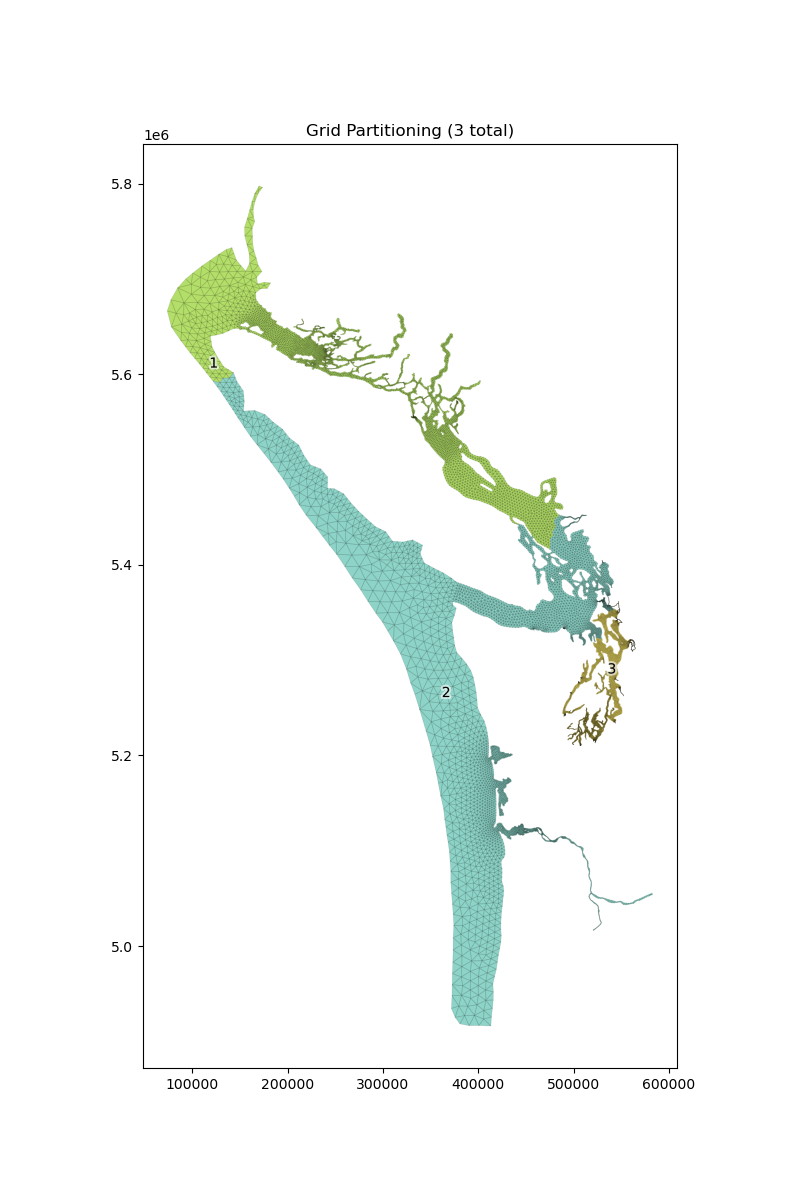

In [4]:
partitions_gdf['color'] = greedy(partitions_gdf)
ax = partitions_gdf.plot('color', figsize=(8,12), zorder=1, cmap="Set3")
partition_eles_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.1, zorder=2)
for i,row in partitions_gdf.iterrows():
    if isinstance(row['geometry'], MultiPolygon):
        coords = [g.representative_point().coords[:][0] for g in row['geometry'].geoms]
    else:
        coords = row['geometry'].representative_point().coords[:]
    for c in coords:
        ax.annotate(i+1, xy=c, ha='center', zorder=3,
                    path_effects=[pe.withStroke(linewidth=3,
                        foreground='white', alpha=0.6)])
ax.set_title(f'Grid Partitioning ({len(partitions_gdf)} total)')